In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
import torchvision.models as models
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
PATH = os.path.abspath(os.getcwd())
PATH

'/home/ademattos/carNocar'

In [3]:
class CustomDset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.images = os.listdir(root_dir)
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.root_dir))
    
    def __getitem__(self, index):
        img_loc = os.path.join(self.root_dir,self.images[index])
        img = Image.open(img_loc).convert("RGB")
        label = 1 if os.path.basename(self.root_dir) == 'cars' else 0
        label = torch.tensor(label).to('cuda')
        
        if self.transform is not None:
            img = self.transform(img).to('cuda')
#             img = img.reshape((3,150,150))
    
        return img,label
        

In [4]:
tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((150,150)),
    torchvision.transforms.ToTensor()])
carDset = CustomDset(PATH+'/data/cars', transform=tfms)
openDset = CustomDset(PATH+'/data/open', transform=tfms)

In [5]:
img,label = carDset.__getitem__(0)
img.shape, label

(torch.Size([3, 150, 150]), tensor(1, device='cuda:0'))

In [6]:
concat_dataset = torch.utils.data.ConcatDataset([carDset,openDset,openDset])
lengths = [int(len(concat_dataset)*0.8), int(len(concat_dataset)*0.2)+1]
train_set, val_set = torch.utils.data.random_split(concat_dataset, lengths)
train_loader = DataLoader(train_set,batch_size=64,shuffle=True)
len(train_set), len(val_set)

(8496, 2125)

In [7]:
train_iter = iter(train_loader)
images,labels = train_iter.next()
images.size(),labels.size()

(torch.Size([64, 3, 150, 150]), torch.Size([64]))

Text(0.5, 1.0, "tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,\n        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,\n        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')")

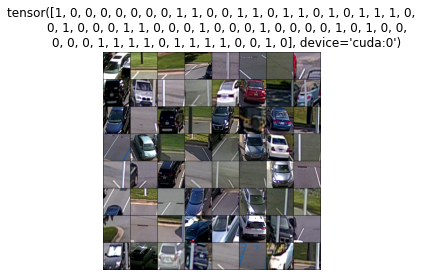

In [8]:
grid = torchvision.utils.make_grid(images.cpu())
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
plt.title(labels)

In [9]:

#model
class ApdNet(torch.nn.Module):
    def __init__(self):
        super(ApdNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(87616, 1000)
        self.fc2 = nn.Linear(1000, 2)
    def forward(self,x):
        #Max pooling over (2,2) window
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [10]:
models.resnet18

<function torchvision.models.resnet.resnet18(pretrained=False, progress=True, **kwargs)>

Epoch [2/2], Step [133,133], Loss: 0.3299, Accuracy: 93.75%: 100%|██████████| 2/2 [00:32<00:00, 16.36s/it] 


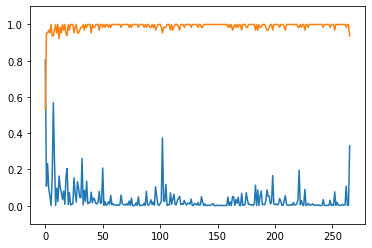

In [11]:
#training
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.cuda()

loss_list, acc_list = [],[]
loss_func = nn.CrossEntropyLoss().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2
total_step = len(train_loader)
for epoch in (t := trange(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = loss_func(outputs,labels)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total = labels.size(0)
        _, predicted = torch.max(outputs.data,1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct/total)
        
        t.set_description('Epoch [{}/{}], Step [{},{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch+1, num_epochs, i+1, total_step, loss.item(),
                       (correct/total)*100))
    
plt.ylim(-0.1,1.1)
plt.plot(loss_list)
plt.plot(acc_list)

In [12]:
# testing validation set
model.eval()
accuracy_list = []
for img, label in val_set:
    img = img.unsqueeze(0)
    with torch.no_grad():
        output = model(img)
    predicted = torch.argmax(output)
    correct = 1 if predicted == label else 0
    accuracy_list.append(correct)

acc = sum(accuracy_list)/len(val_set)
print(acc)

0.9948235294117647


In [16]:
model.eval()
img = Image.open(PATH+'/test_images/no_car.png').convert("RGB")
img = torchvision.transforms.functional.resize(img, (150,150))
img = torchvision.transforms.functional.to_tensor(img)
img = img.unsqueeze(0).to('cuda')
print(img.shape)
with torch.no_grad():
    output = model(img)
output


torch.Size([1, 3, 150, 150])


tensor([[ 4.8257, -4.9024]], device='cuda:0')

In [14]:
torch.save(model.state_dict(), 'models/bad_model.pt')